In [3]:
import sys
sys.path.append('./../')
import src
from src import proyecto_1
from src.utils import utils
from src.pipelines import modeling
from src.pipelines import ingestion
from src.pipelines import transformation
import pandas as pd
import numpy as np
import os
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from numpy import savetxt
from matplotlib import pyplot
from sklearn.tree import DecisionTreeClassifier

In [4]:
proyecto_1.main()

./../src/pipelines/feature_engineering.py:14: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.inputs = df.drop(['latitud', 'longitud', 'codigo_cierre','fecha_creacion','incidente_c4'], axis=1)


In [5]:
c5_inputs = utils.load_df('output/fe_df.pkl')

### Ordenamiento del dataframe de manera cronologica (De fecha mas antigua a mas reciente)

In [6]:
c5_inputs = c5_inputs.sort_values(by=['año_creacion','mes'],ascending=True)

In [7]:
c5_inputs.nunique()

dia_semana               7
delegacion_inicio       16
clas_con_f_alarma        4
tipo_entrada             9
mes                     12
label                    2
año_creacion             8
sin_time             76589
cos_time             78364
dtype: int64

In [8]:
c5_inputs.head()

,dia_semana,delegacion_inicio,clas_con_f_alarma,tipo_entrada,mes,label,año_creacion,sin_time,cos_time
372610,Martes,IZTAPALAPA,EMERGENCIA,LLAMADA DEL 066,1,0,2013,-0.321921,0.946766
372616,Martes,IZTAPALAPA,EMERGENCIA,LLAMADA DEL 066,1,0,2013,-0.443788,0.896132
372626,Martes,CUAUHTEMOC,EMERGENCIA,LLAMADA DEL 066,1,0,2013,-0.438110,0.898922
372644,Martes,IZTACALCO,EMERGENCIA,CÁMARA,1,0,2013,-0.241710,0.970348
372652,Martes,XOCHIMILCO,EMERGENCIA,LLAMADA DEL 066,1,0,2013,-0.678213,0.734865


### Definimos los nombres de las variables que vamos a usar

In [9]:
names=np.array(c5_inputs.dia_semana.unique())
names=np.append(names,np.array(c5_inputs.delegacion_inicio.unique()))
names=np.append(names,np.array(c5_inputs.clas_con_f_alarma.unique()))
names=np.append(names,np.array(c5_inputs.tipo_entrada.unique()))
names=np.append(names,np.array(['año','mes','sin_time', 'cos_time']))

### Definimos los transformadores de las variables categoricas y la imputacion de datos con la media de coseno y seno del tiempo

In [10]:
transformers = [('one_hot', OneHotEncoder(), [ 'dia_semana','delegacion_inicio','clas_con_f_alarma','tipo_entrada']),
               ('año', SimpleImputer(strategy="mean"), ['año_creacion']),
               ('mes', SimpleImputer(strategy="mean"), ['mes']),
               ('impute_sin_time', SimpleImputer(strategy="median"), ['sin_time']),
               ('impute_cos_time', SimpleImputer(strategy="median"), ['cos_time'])]

In [11]:
col_trans = ColumnTransformer(transformers, remainder="drop", n_jobs=-1, verbose=True)
#col_trans = ColumnTransformer(transformers, n_jobs=-1, verbose=True)

In [12]:
col_trans.fit(c5_inputs)

ColumnTransformer(n_jobs=-1,
                  transformers=[('one_hot', OneHotEncoder(),
                                 ['dia_semana', 'delegacion_inicio',
                                  'clas_con_f_alarma', 'tipo_entrada']),
                                ('año', SimpleImputer(), ['año_creacion']),
                                ('mes', SimpleImputer(), ['mes']),
                                ('impute_sin_time',
                                 SimpleImputer(strategy='median'),
                                 ['sin_time']),
                                ('impute_cos_time',
                                 SimpleImputer(strategy='median'),
                                 ['cos_time'])],
                  verbose=True)

In [13]:
c5_input_vars = col_trans.transform(c5_inputs)

In [14]:
c5_input_vars.shape

(1382537, 40)

### Definimos la matriz de las variables para la prediccion y la etiqueta que queremos predecir

In [15]:
X = c5_input_vars
y = c5_inputs.label.values.reshape(c5_input_vars.shape[0],)

### Aplicamos Grid Search para comparar distintos modelos

In [16]:
import time 

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit

# ocuparemos un RF
classifier = RandomForestClassifier(oob_score=True, random_state=1234)
# separando en train, test
X_train, X_test, y_train, y_test = train_test_split(X, y)

# definicion de los hiperparametros que queremos probar
hyper_param_grid = {'n_estimators': [10,20], 
                    'max_depth': [1, 2, 5],
                    'min_samples_split': [2, 4]}

#Time Series cross-validator
tscv = TimeSeriesSplit(n_splits=8)

# ocupemos grid search!
gs = GridSearchCV(classifier, 
                           hyper_param_grid, 
                           scoring = 'precision',
                           cv = tscv,
                            
                           n_jobs = -1)
start_time = time.time()
gs.fit(X_train, y_train)
print("Tiempo en ejecutar: ", time.time() - start_time)

Tiempo en ejecutar:  142.60932159423828


/home/yusuri/.pyenv/versions/itam_intro_to_ds/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/yusuri/.pyenv/versions/itam_intro_to_ds/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [17]:
gs.cv_results_

{'mean_fit_time': array([ 4.44284573,  8.59002686,  4.37258705,  8.41941583,  5.82705274,
        11.06921473,  5.92028362, 11.3021577 , 11.93694949, 21.96077624,
        11.32933751, 14.67109585]),
 'std_fit_time': array([ 2.4955422 ,  4.81954218,  2.36980823,  4.46062453,  3.10808679,
         6.02621726,  3.25163787,  5.89075824,  6.00611293, 11.57191285,
         5.92183215,  4.89150587]),
 'mean_score_time': array([0.23179355, 0.3465541 , 0.22782215, 0.35846889, 0.23060581,
        0.36074701, 0.23261097, 0.3544862 , 0.24403578, 0.34696159,
        0.22370994, 0.24932161]),
 'std_score_time': array([0.02027784, 0.02437103, 0.01176019, 0.01842991, 0.03975834,
        0.02918402, 0.01116419, 0.02067383, 0.02274967, 0.03592564,
        0.02276115, 0.08872217]),
 'param_max_depth': masked_array(data=[1, 1, 1, 1, 2, 2, 2, 2, 5, 5, 5, 5],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
 

In [18]:
gs.best_params_

{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 20}

In [19]:
gs.best_score_

0.9997168966100652

In [20]:
gs.best_estimator_

RandomForestClassifier(max_depth=5, n_estimators=20, oob_score=True,
                       random_state=1234)

In [21]:
gs.best_estimator_.oob_score_

0.8036140348846853

### De los mejores estimadores creamos el modelo para la nuectros valores de prueba

In [22]:
rfc=RandomForestClassifier(random_state=1234, min_samples_split=2, n_estimators= 20, max_depth=5)
rfc.fit(X_train, y_train)
pred=rfc.predict(X_test)

### Vemos su Accuracy 

In [23]:
from sklearn.metrics import accuracy_score
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,pred))

Accuracy for Random Forest on CV data:  0.8024910671662303


In [24]:
importance = gs.best_estimator_.feature_importances_

### Buscamos las variables que aportan mas al modelo

In [25]:
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.00036
Feature: 1, Score: 0.00001
Feature: 2, Score: 0.00002
Feature: 3, Score: 0.00001
Feature: 4, Score: 0.00004
Feature: 5, Score: 0.00004
Feature: 6, Score: 0.00060
Feature: 7, Score: 0.00002
Feature: 8, Score: 0.00121
Feature: 9, Score: 0.00192
Feature: 10, Score: 0.00003
Feature: 11, Score: 0.01202
Feature: 12, Score: 0.01439
Feature: 13, Score: 0.00018
Feature: 14, Score: 0.00006
Feature: 15, Score: 0.00141
Feature: 16, Score: 0.00065
Feature: 17, Score: 0.00034
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00002
Feature: 20, Score: 0.00408
Feature: 21, Score: 0.00003
Feature: 22, Score: 0.00067
Feature: 23, Score: 0.00179
Feature: 24, Score: 0.15678
Feature: 25, Score: 0.25462
Feature: 26, Score: 0.29417
Feature: 27, Score: 0.00003
Feature: 28, Score: 0.08125
Feature: 29, Score: 0.00112
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.01396
Feature: 32, Score: 0.01597
Feature: 33, Score: 0.08169
Feature: 34, Score: 0.00639
Feature: 35, Score: 0.00005
Fe

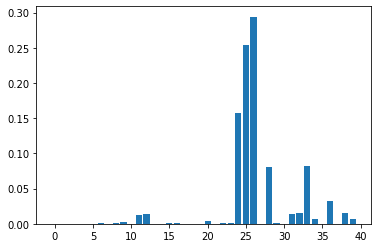

In [26]:
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

### Vemos los nombres de las variables que aportan mas al modelo.

In [27]:
dataset_2 = pd.DataFrame({'importance': importance, 'col_name': names}).sort_values(by='importance',ascending=False)
dataset_3 = dataset_2[dataset_2['importance']>=0.07]
dataset_3['importance'] = pd.Series(["{0:.0f}%".format(val * 100) for val in dataset_3['importance']], index = dataset_3.index)
dataset_3

/home/yusuri/.pyenv/versions/itam_intro_to_ds/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,importance,col_name
26,29%,DELITO
25,25%,FALSA ALARMA
24,16%,URGENCIAS MEDICAS
33,8%,LLAMADA APP911
28,8%,CÁMARA


In [28]:
import scipy.sparse

In [29]:
df=pd.DataFrame.sparse.from_spmatrix(c5_input_vars)
df.columns=names
df['y']=c5_inputs.label.values.reshape(c5_input_vars.shape[0],)

In [30]:
selection=list(dataset_3.col_name.values)
selection.append('y')

In [31]:
path = 'output/variables_df.pkl'
utils.save_df(df[selection], path)

## Modeling

In [32]:
path = 'output/variables_df.pkl'

In [33]:
modeling.modeling(path)

/home/yusuri/.pyenv/versions/itam_intro_to_ds/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/yusuri/.pyenv/versions/itam_intro_to_ds/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


## Model Evaluation

In [34]:
c5_evaluation = utils.load_df('output/model_loop.pkl')

In [35]:
c5_evaluation

[GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=8),
              estimator=DecisionTreeClassifier(random_state=123), n_jobs=-1,
              param_grid={'max_depth': [1, 2, 5, None],
                          'min_samples_leaf': [2, 4]},
              scoring='precision'),
 GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=8),
              estimator=RandomForestClassifier(oob_score=True, random_state=123),
              n_jobs=-1,
              param_grid={'max_depth': [1, 2, 5, None],
                          'min_samples_leaf': [2, 4], 'n_estimators': [10, 20]},
              scoring='precision')]

In [36]:
df_test=pd.DataFrame.sparse.from_spmatrix(X_test)
df_test.columns = names
selection_test=list(dataset_3.col_name.values)
test_ = df_test[selection_test]

In [37]:
y_test

array([0, 1, 1, ..., 0, 0, 0])

In [38]:
c5_evaluation[0].predict(test_)

array([0, 0, 0, ..., 0, 0, 0])

In [39]:
predicted_labels_1 = c5_evaluation[0].predict(test_)
predicted_labels_2 = c5_evaluation[1].predict(test_)
predicted_scores_1 = c5_evaluation[0].predict_proba(test_)
predicted_scores_2 = c5_evaluation[1].predict_proba(test_)

### Medidas de desempeño

#### ROC y AUC

In [40]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

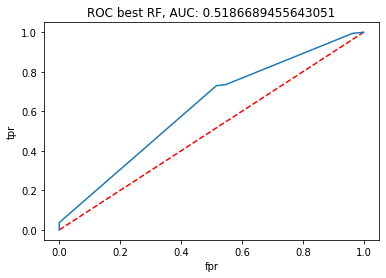

In [41]:
%matplotlib inline
fpr, tpr, thresholds = roc_curve(y_test, predicted_scores_2[:,1], pos_label=1)

plt.clf()
plt.plot([0,1],[0,1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(y_test, predicted_labels_2)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()

### Matriz de confusion

In [42]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, predicted_labels_2)

array([[274721,      1],
       [ 68265,   2648]])

### Accuracy

In [43]:

from sklearn.metrics import accuracy_score

accuracy_score(y_test, predicted_labels_2)

0.8024910671662303

In [44]:
#### Precision, recall, thresholds
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds_2 = precision_recall_curve(y_test, predicted_scores_2[:,1], pos_label=1)

In [45]:
thresholds_2 = np.append(thresholds_2, 1)

In [46]:
(precision.shape, recall.shape, thresholds_2.shape)

((8,), (8,), (8,))

### Reporte de metricas

In [47]:
def get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2):
    df_1 = pd.DataFrame({'threshold': thresholds_2,'precision': precision,
                    'recall': recall})
    df_1['f1_score'] = 2 * (df_1.precision * df_1.recall) / (df_1.precision + df_1.recall)
    
    df_2 = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': thresholds})
    df_2['tnr'] = 1 - df_2['fpr']
    df_2['fnr'] = 1 - df_2['tpr']
    
    df = df_1.merge(df_2, on="threshold")
    
    return df

In [48]:
metrics_report = get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2)
metrics_report

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
0,0.152681,0.205167,1.000000,0.340479,1.000000,1.000000,0.000000,0.000000
1,0.169874,0.210357,0.994049,0.347233,0.994049,0.963196,0.036804,0.005951
2,0.206874,0.257467,0.735450,0.381410,0.735450,0.547495,0.452505,0.264550
3,0.209388,0.257542,0.734929,0.381422,0.734929,0.546891,0.453109,0.265071
4,0.226581,0.267290,0.729923,0.391293,0.729923,0.516486,0.483514,0.270077
5,0.510240,0.999622,0.037342,0.071994,0.037342,0.000004,0.999996,0.962658
6,0.527433,1.000000,0.036679,0.070762,0.036679,0.000000,1.000000,0.963321


## Me falta crear la funcion que haga esto asi como guardarlo en un pickle metricas_offline.pkl

## Bias_fairness

In [49]:
import pandas as pd
import seaborn as sns
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot

# import warnings; warnings.simplefilter('ignore')

%matplotlib inline

ModuleNotFoundError: No module named 'aequitas'

In [ ]:
c5_bias_fiarness = transformation.load_ingestion('output/ingest_df.pkl')

In [ ]:
c5_bias_fiarness = c5_bias_fiarness.rename(columns={'label':'label_value'})
c5_bias_fiarness['score'] = '1'
c5_bias_fiarness = c5_bias_fiarness.drop(['tipo_entrada','clas_con_f_alarma','dia_semana','codigo_cierre','incidente_c4','fecha_creacion','hora_creacion','latitud','longitud','mes'], axis=1)

## Aequitas Group() Class

In [ ]:
g = Group()

In [ ]:
xtab, _ = g.get_crosstabs(c5_bias_fiarness)

In [ ]:
absolute_metrics = g.list_absolute_metrics(xtab)

In [ ]:
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

In [ ]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

In [ ]:
aqp = Plot()

In [ ]:
fnr = aqp.plot_group_metric(xtab, 'fpr')

In [ ]:
fnr = aqp.plot_group_metric(xtab, 'fpr', min_group_size=0.05)

In [ ]:
p = aqp.plot_group_metric_all(xtab, metrics=['ppr','pprev','fdr','fpr'], ncols=4)

In [ ]:
a = aqp.plot_group_metric_all(xtab, ncols=3)

## Aequitas Bias() Class

In [ ]:
b = Bias()

In [ ]:
bdf = b.get_disparity_predefined_groups(xtab, original_df=df, 
                                        ref_groups_dict={'race':'Caucasian', 'sex':'Male', 'age_cat':'25 - 45'}, 
                                        alpha=0.05, check_significance=True, 
                                        mask_significance=True)
bdf.style 

In [155]:
import sklearn.metrics as metrics
from datetime import datetime

In [70]:
def precision_at_k(y_true, y_scores, k):
    threshold = np.sort(y_scores)[::-1][int(k*len(y_scores))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores])

    return metrics.precision_score(y_true, y_pred)


In [71]:
def recall_at_k(y_true, y_scores, k):
   threshold = np.sort(y_scores)[::-1][int(k*len(y_scores))]
   y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores])

   return metrics.recall_score(y_true, y_pred)

In [257]:
def get_top_k(y_scores,k):
    ordena_k = sorted(y_scores,reverse=True)
    k_porc = int(len(y_scores)*k)
    top = ordena_k[:k_porc]
    return top

In [262]:
def get_top_k2(y_true,y_scores,k):
    ordena_k = sorted(y_scores,reverse=True)
    k_porc = int(len(y_scores)*k)
    top = ordena_k[:k_porc]
    return top


In [267]:
def pr_k_curve(y_true, y_scores, save_target):
    k_values = list(np.arange(0.1, 1.1, 0.1))
    pr_k = pd.DataFrame()

    for k in k_values:
        d = dict()
        d['k'] = k
        ## get_top_k es una función que ordena los scores de
        ## mayor a menor y toma los k% primeros
        top_k = get_top_k(y_scores, k)
        d['precision'] = precision_at_k(top_k)
        d['recall'] = recall_at_k(top_k, predictions)
        #d['precision'] = precision_at_k(y_true, y_scores,k)
        #d['recall'] = recall_at_k(y_true, y_scores, k)

        pr_k = pr_k.append(d, ignore_index=True)

    # para la gráfica
    fig, ax1 = plt.subplots()
    ax1.plot(pr_k['k'], pr_k['precision'], label='precision')
    ax1.plot(pr_k['k'], pr_k['recall'], label='recall')
    plt.legend()

    if save_target is not None:
        plt.savefig(save_target, dpi=300)

    return pr_k

In [270]:
pr_k_curve(y_test, predicted_scores_2[:,1],k)

IndexError: index 345635 is out of bounds for axis 0 with size 345635

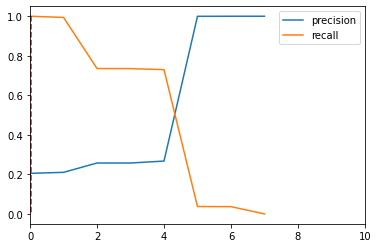

In [306]:
fig, ax1 = plt.subplots()
ax1.plot(precision, label='precision')
ax1.plot(recall, label='recall')
ax1.plot([k,k],[1,0], 'k--', c='red')
plt.xlim(0,10)
plt.legend()

In [263]:
predicted_scores_2

array([[0.77341941, 0.22658059],
       [0.83012576, 0.16987424],
       [0.77341941, 0.22658059],
       ...,
       [0.77341941, 0.22658059],
       [0.77341941, 0.22658059],
       [0.77341941, 0.22658059]])

In [272]:
recall

array([1.        , 0.99404905, 0.73545048, 0.73492872, 0.72992258,
       0.03734153, 0.03667875, 0.        ])

In [187]:
#c=c5_inputs.groupby('dia_semana').count()
#/c5_inputs.groupby('año_creacion').count()
#k=c['clas_con_f_alarma'].mean()
min_fecha = '01/01/2014'
max_fecha = '12/10/2020'
min_fecha = datetime.strptime(min_fecha, '%d/%m/%Y')
max_fecha = datetime.strptime(max_fecha, '%d/%m/%Y')
dias = max_fecha-min_fecha
dias

datetime.timedelta(days=2476)

In [294]:
ambulancias = 20
dias=2476
acc = c5_inputs['dia_semana'].count()
acc_x_dia = acc/dias
k = ambulancias / acc_x_dia
k

0.0358182095669049

In [190]:
precision_at_k(y_test,pred,k)

0.20516730076525816

In [191]:
recall_at_k(y_test,pred, k)

1.0